In [3]:
pip install patool

In [5]:
pip install -U --no-cache-dir gdown --pre

In [6]:
# import librarys
import numpy as np
import csv
import os
import patoolib
import cv2
import time
from PIL import Image, ImageFilter
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
from google.colab.patches import cv2_imshow
import pandas as pd

from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import BatchNormalization
from keras import Model
from keras.preprocessing import image

In [7]:
#download dataset from google drive
!gdown --id 1IxWGcjlOBfgFBA1WOe-Ehlx3qYRXpPI1

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1IxWGcjlOBfgFBA1WOe-Ehlx3qYRXpPI1
To: /content/10sentence.rar
100% 484M/484M [00:01<00:00, 319MB/s]


In [16]:
# extract the dataset
patoolib.extract_archive("10sentence.rar")

patool: Extracting 10sentence.rar ...
patool: running /usr/bin/unrar x -- /content/10sentence.rar
patool:     with cwd='./Unpack_n3gycnt8'
patool: ... 10sentence.rar extracted to `10sentence'.


'10sentence'

In [9]:
# define feature extraction model

inputs = Input(shape=[224, 224, 1])

cnnModel = Convolution2D(filters=32, kernel_size=3, activation='relu', input_shape=[224, 224, 1])(inputs)
cnnModel = BatchNormalization()(cnnModel)
cnnModel = MaxPooling2D(pool_size=2, strides=2)(cnnModel)

cnnModel = Convolution2D(filters=64, kernel_size=3, activation='relu')(cnnModel)
cnnModel = BatchNormalization()(cnnModel)
cnnModel = MaxPooling2D(pool_size=2, strides=2)(cnnModel)

cnnModel = Convolution2D(filters=128, kernel_size=3, activation='relu')(cnnModel)
cnnModel = BatchNormalization()(cnnModel)
cnnModel = MaxPooling2D(pool_size=2, strides=2)(cnnModel)

cnnModel = Convolution2D(filters=256, kernel_size=3, activation='relu')(cnnModel)
cnnModel = BatchNormalization()(cnnModel)
cnnModel = MaxPooling2D(pool_size=2, strides=2)(cnnModel)

cnnModel = Convolution2D(filters=512, kernel_size=3, activation='relu')(cnnModel)
cnnModel = BatchNormalization()(cnnModel)
cnnModel = MaxPooling2D(pool_size=2, strides=2)(cnnModel)

cnnModel = Convolution2D(filters=1024, kernel_size=3, activation='relu')(cnnModel)
cnnModel = BatchNormalization()(cnnModel)
cnnModel = MaxPooling2D(pool_size=2, strides=2)(cnnModel)

cnnModel = Dropout(0.5)(cnnModel)
outputs = Flatten()(cnnModel)

cnnModel = Model(inputs=inputs, outputs=outputs)
cnnModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 109, 109, 64)     256   

In [10]:
# store dataset file path to a variable and find min and max frame size
datasetFilePath = []
maxFrame = 0
minFrame = 500
for index1, folderName in enumerate(os.listdir("10sentence/")):
    for index2, folderName2 in enumerate(os.listdir("10sentence/" + folderName)):
        framesLength = len(os.listdir("10sentence/" + folderName + "/" + folderName2))
        if(framesLength > maxFrame):
          maxFrame = framesLength
        if(framesLength < minFrame):
          minFrame = framesLength
        datasetFilePath.append([folderName, folderName2])
print("Min frame: ", minFrame)
print("Max frame: ", maxFrame)

Min frame:  11
Max frame:  63


video 206 :  do not worry


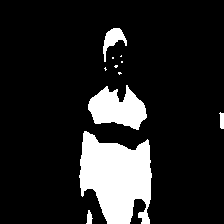

In [11]:
# segment, extract features and save features to CSV file for video frames
for i1, folderName in enumerate(datasetFilePath):
    sentence = []
    for i, fileName in enumerate(os.listdir("10sentence/" + folderName[0] + "/" + folderName[1])):
        if fileName.endswith(".jpg"):
          img = cv2.imread("10sentence/" + folderName[0] + "/" + folderName[1] + "/" + fileName)
          img = cv2.resize(img, (224, 224))

          # skin detection 
          # https://github.com/CHEREF-Mehdi/SkinDetection/blob/master/SkinDetection.py

          # converting from gbr to hsv color space
          img_HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
          # skin color range for hsv color space
          HSV_mask = cv2.inRange(img_HSV, (0, 15, 0), (17, 170, 255))
          HSV_mask = cv2.morphologyEx(HSV_mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))

          # converting from gbr to YCbCr color space
          img_YCrCb = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
          # skin color range for hsv color space
          YCrCb_mask = cv2.inRange(img_YCrCb, (0, 135, 85), (255, 180, 135))
          YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_OPEN, np.ones((3, 3), np.uint8))

          # merge skin detection (YCbCr and hsv)
          global_mask = cv2.bitwise_and(YCrCb_mask, HSV_mask)
          global_mask = cv2.medianBlur(global_mask, 3)
          global_mask = cv2.morphologyEx(global_mask, cv2.MORPH_OPEN, np.ones((4, 4), np.uint8))

          HSV_result = cv2.bitwise_not(HSV_mask)
          YCrCb_result = cv2.bitwise_not(YCrCb_mask)
          global_result = cv2.bitwise_not(global_mask)
          
          clear_output(wait=True)
          print("video",i1,": ",folderName[0])
          cv2_imshow(global_result)
          cv2.waitKey(1)
          
          global_result = image.img_to_array(global_result)
          global_result = np.expand_dims(global_result, axis=0)
          r1 = cnnModel.predict(global_result)
          sentence.append(r1[0])

    # pad missing frames
    for i in range(len(sentence), maxFrame):
        paddingFeauters=[]
        for j in range(0,len(sentence[0])):
          arr1 = np.array([0])
          arr2 = np.array(paddingFeauters)
          paddingFeauters = np.concatenate((arr1, arr2))
        sentence.append(paddingFeauters)

    # prepare header for csv file
    header=[]
    for j in range(0,len(sentence[0])):
        p = 'F-'+str(j)
        arr1 = np.array([p])
        arr2 = np.array(header)
        header = np.concatenate((arr1, arr2))
    header = header[::-1]

    # save vedio featuers to csv file
    for i in range(0, maxFrame):
        a = np.array(sentence[i])
        a = np.append(a, folderName[0])
        if i1 == 0:
          h = np.array(header)
          h = np.append(h, "class")
        with open('dataset_v1.csv', 'a+', newline='') as f:
            write = csv.writer(f)
            if i1 == 0 and i == 0:
              write.writerow(h)
            write.writerow(a)

In [15]:
dataset_train = pd.read_csv('dataset_v1.csv')
print(dataset_train)

            F-0       F-1       F-2       F-3        F-4       F-5  F-6  \
0      4.307698  7.933354  0.002982  7.865017   9.594213  1.175911  0.0   
1      3.624532  7.638630  0.358289  6.832114  11.712733  3.011297  0.0   
2      4.909181  8.484513  0.000000  7.831418  11.029656  1.910458  0.0   
3      4.381569  8.296061  0.000000  8.583636  10.520808  1.514985  0.0   
4      5.181141  8.855169  0.504565  7.661772  10.921311  1.622769  0.0   
...         ...       ...       ...       ...        ...       ...  ...   
13036  0.000000  0.000000  0.000000  0.000000   0.000000  0.000000  0.0   
13037  0.000000  0.000000  0.000000  0.000000   0.000000  0.000000  0.0   
13038  0.000000  0.000000  0.000000  0.000000   0.000000  0.000000  0.0   
13039  0.000000  0.000000  0.000000  0.000000   0.000000  0.000000  0.0   
13040  0.000000  0.000000  0.000000  0.000000   0.000000  0.000000  0.0   

            F-7       F-8  F-9  ...    F-1015    F-1016  F-1017    F-1018  \
0      0.481354  0.000